# **Pneumonia Detection Challenge**

### **Context**

Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation
of the lungs. In this challenge, you’re required to build an algorithm to detect a visual signal for pneumonia in medical
images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

In [ ]:
pip install pydicom


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
import keras
import os
import zipfile
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from matplotlib import patches
import zipfile
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

import pydicom
import matplotlib.patches as patches



**Step-1:Loading Data**

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
stage_train_df=pd.read_csv('/content/drive/MyDrive/DataScience/Capstone_Project/Pneumonia_Detection_Dataset/stage_2_train_labels.csv')
stage_class_info_df=pd.read_csv('/content/drive/MyDrive/DataScience/Capstone_Project/Pneumonia_Detection_Dataset/stage_2_detailed_class_info.csv')

In [7]:
#Printing few records from train data and class info data

print('Below is the 5 records from train data\n',stage_train_df.head())
print('Below is the 5 records from class info data\n',stage_class_info_df.head())

Below is the 5 records from train data
                               patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
Below is the 5 records from class info data
                               patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


In [8]:
# Shape of the data

print('Shape of the train data: ',stage_train_df.shape)
print('Shape of the class info data: ',stage_class_info_df.shape)

Shape of the train data:  (30227, 6)
Shape of the class info data:  (30227, 2)


In [9]:
# Checking for Null Values

print('Null values in train data: \n',stage_train_df.isnull().sum())
print('Null values in class info data: \n',stage_class_info_df.isnull().sum())

Null values in train data: 
 patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64
Null values in class info data: 
 patientId    0
class        0
dtype: int64


In [12]:
## To check duplicate records

dup=stage_train_df[stage_train_df.duplicated()]
dup

,patientId,x,y,width,height,Target


In [13]:
dup1=stage_class_info_df[stage_class_info_df.duplicated()]
dup1

,patientId,class
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
15,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity
17,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
20,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity
...,...,...
30209,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,Lung Opacity
30215,c1cddf32-b957-4753-acaa-472ab1447e86,Lung Opacity
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity


As there are duplicate rows in the dataset we need to process these duplicate rows.

In [14]:
stage_class_info_df = stage_class_info_df.drop_duplicates()

In [15]:
dup1=stage_class_info_df[stage_class_info_df.duplicated()]
dup1

,patientId,class


**Step 2: Map training and testing images to its classes**



In [16]:
# Merge training data with class info on 'patientId'
merged_df = pd.merge(stage_train_df, stage_class_info_df, on='patientId')

# Check the merged dataset
print(merged_df.head())

                              patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  


In [17]:
# Merge annotations and class labels
train_data_annotated = pd.merge(stage_train_df, stage_class_info_df, on='patientId', how='left')

In [18]:
# Only images with actual annotations (Target == 1)
annotated_train_images = train_data_annotated[train_data_annotated['Target'] == 1]

In [19]:
annotated_train_images.head()

,patientId,x,y,width,height,Target,class
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,Lung Opacity


In [20]:
# Paths
train_zip_path = '/content/drive/MyDrive/DataScience/Capstone_Project/Pneumonia_Detection_Dataset/stage_2_train_images.zip'
test_zip_path = '/content/drive/MyDrive/DataScience/Capstone_Project/Pneumonia_Detection_Dataset/stage_2_test_images.zip'
output_dir = '/content/images/'

# Unzip train images
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir + 'train/')

# Unzip test images
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir + 'test/')

In [21]:
train_image_dir = os.path.join(output_dir, 'train', 'stage_2_train_images')
test_image_dir = os.path.join(output_dir, 'test', 'stage_2_test_images')  # if structured similarly

# List actual image files
train_image_files = os.listdir(train_image_dir)
test_image_files = os.listdir(test_image_dir)

# Remove .dcm extension
train_image_ids = [filename.replace('.dcm', '') for filename in train_image_files]
test_image_ids = [filename.replace('.dcm', '') for filename in test_image_files]

In [22]:
merged_df['image_exists'] = merged_df['patientId'].isin(train_image_ids)
mapped_train_df = merged_df[merged_df['image_exists'] == True]

In [23]:
mapped_train_df.count()

,0
patientId,30227
x,9555
y,9555
width,9555
height,9555
Target,30227
class,30227
image_exists,30227


In [ ]:
# Create test DataFrame
test_df = pd.DataFrame({'patientId': test_image_ids})
test_df['image_exists'] = test_df['patientId'].isin(test_image_ids)

In [ ]:
test_df.head()

,patientId,image_exists
0,22465003-1c9f-4ced-891c-7cc23dad7318,True
1,2be12301-eb2a-409d-8a84-92bf849c3247,True
2,13213d41-f74c-4806-a6b0-1703893e5a80,True
3,0490b4dd-cb7c-496a-b0ea-12244a055d57,True
4,2c0aad4a-7618-4254-933f-17c5d64331e3,True


**Map training and testing images to its annotations**

In [ ]:
# Filter rows where pneumonia is present (Target == 1)
bbox_df = stage_train_df[stage_train_df['Target'] == 1]

# Group bounding boxes per image
from collections import defaultdict

# Dict: {patientId: [list of bbox dicts]}
train_annotations = defaultdict(list)

# Groups all bounding boxes per patient/image into a dictionary
for _, row in bbox_df.iterrows():
    patient_id = row['patientId']
    bbox = {
        'x': row['x'],
        'y': row['y'],
        'width': row['width'],
        'height': row['height']
    }
    train_annotations[patient_id].append(bbox)

In [ ]:
# Add annotation list (empty if none)
mapped_train_df['annotations'] = mapped_train_df['patientId'].map(train_annotations)

# Fill NaNs (i.e., no annotation) with empty lists
mapped_train_df['annotations'] = mapped_train_df['annotations'].apply(lambda x: x if isinstance(x, list) else [])

In [ ]:
mapped_train_df[['patientId', 'Target', 'class', 'annotations']].head()


,patientId,Target,class,annotations
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,No Lung Opacity / Not Normal,[]
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,No Lung Opacity / Not Normal,[]
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,No Lung Opacity / Not Normal,[]
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,Normal,[]
4,00436515-870c-4b36-a041-de91049b9ab4,1,Lung Opacity,"[{'x': 264.0, 'y': 152.0, 'width': 213.0, 'hei..."


**Preprocessing and Visualisation of different classes**

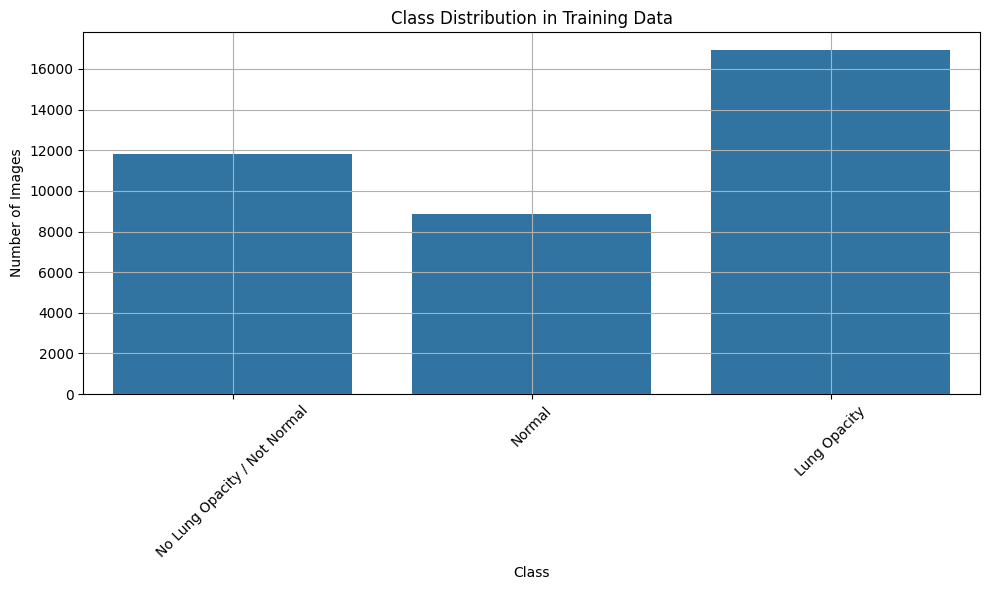

In [ ]:
#Visualise Class Distribution

plt.figure(figsize=(10,6))
sns.countplot(data=mapped_train_df, x='class')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Visualize Sample DICOM Images with Bounding Boxes


# Function to display images with BoundingBox

def show_image_with_boxes(patient_id, image_dir, annotations_dict):
    dcm_path = os.path.join(image_dir, f"{patient_id}.dcm")
    dicom = pydicom.dcmread(dcm_path)
    img = dicom.pixel_array

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(img, cmap='gray')

    # Draw bounding boxes if any
    for ann in annotations_dict.get(patient_id, []):
        rect = patches.Rectangle(
            (ann['x'], ann['y']),
            ann['width'],
            ann['height'],
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)

    ax.set_title(f"Patient ID: {patient_id}")
    plt.axis('off')
    plt.show()


Class: No Lung Opacity / Not Normal, Patient ID: ca61ab53-b836-451e-b57a-3a8197a8b5ef


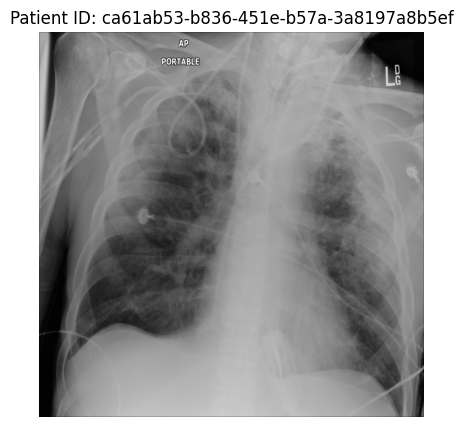

Class: No Lung Opacity / Not Normal, Patient ID: 37e921ef-53bc-4b10-82cb-82aec4555655


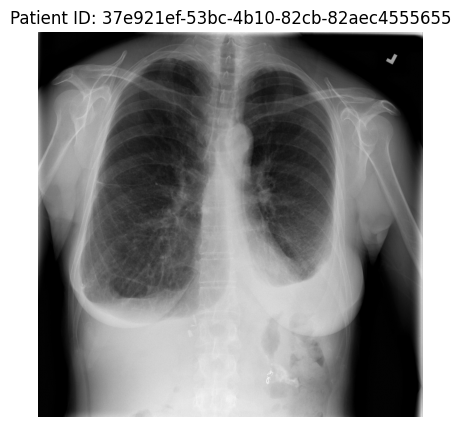

Class: No Lung Opacity / Not Normal, Patient ID: 2d98d4dc-bc2e-4c50-9ca6-5fbffa75d006


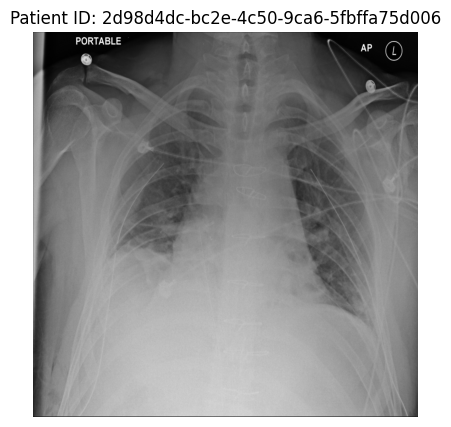

Class: Normal, Patient ID: 634dc2f2-faf9-44da-a5f2-011870025110


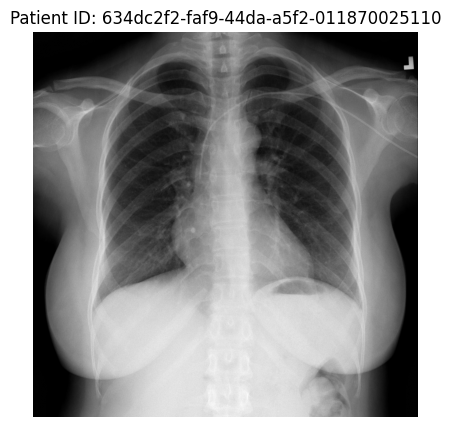

Class: Normal, Patient ID: e96a0239-5630-4b54-8e34-d17a3bed5841


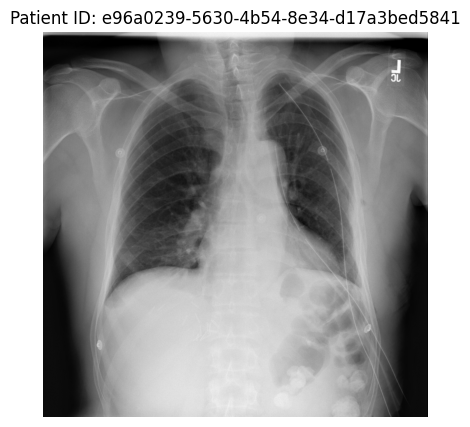

Class: Normal, Patient ID: 0989935f-d8e5-4b59-a72e-077da14ba7f6


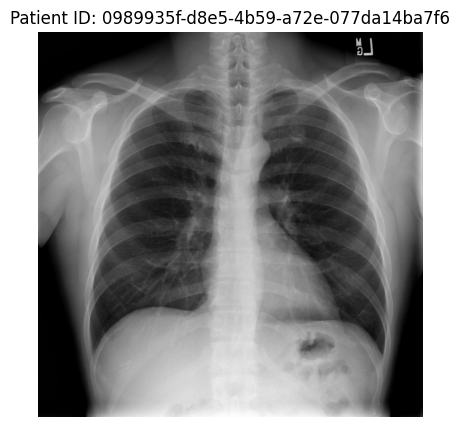

Class: Lung Opacity, Patient ID: 4e00fa41-f9dc-4826-ae11-3c2c0d056ff1


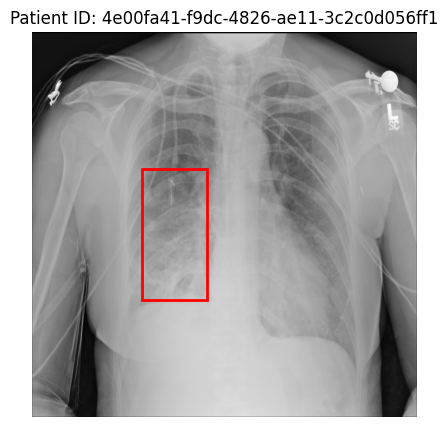

Class: Lung Opacity, Patient ID: 51b0e89f-608a-4040-9d0d-694ebe072c28


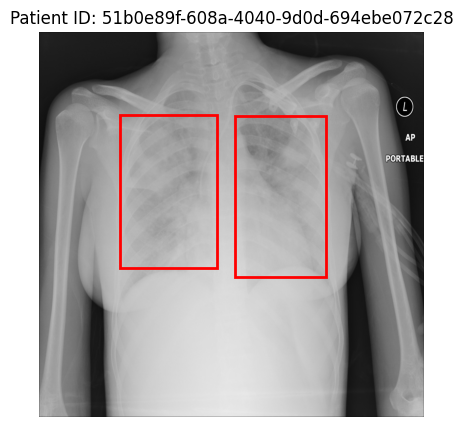

Class: Lung Opacity, Patient ID: da69ffb8-40fa-49ea-b11e-9ddff40845e8


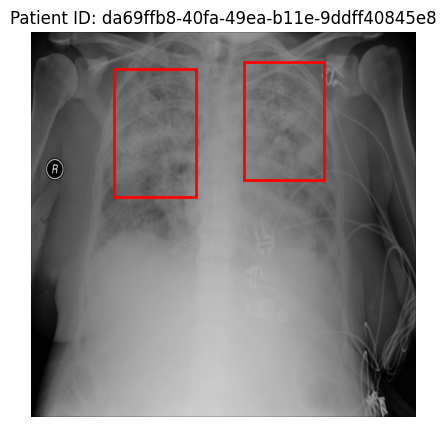

In [ ]:
samples_per_class = 3

for cls in mapped_train_df['class'].unique():
    class_subset = mapped_train_df[mapped_train_df['class'] == cls]
    sampled_class_df = class_subset.sample(n=min(samples_per_class, len(class_subset)), random_state=42)

    for _, row in sampled_class_df.iterrows():
        print(f"Class: {cls}, Patient ID: {row['patientId']}")
        show_image_with_boxes(row['patientId'], train_image_dir, train_annotations)

**Display images with bounding box**